# Environment

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import pickle
import os
from pathlib import Path
import mygene

wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_CUTandTAG/custom_pipeline'
os.chdir(wd_dir)

# Get the current working directory
current_dir = os.getcwd()

# Always reload functions
import importlib
import functions_Coverage
importlib.reload(functions_Coverage)
from functions_Coverage import *


In [2]:
cpg_file = "DATA/cpg_islands.bed"

In [3]:
# Path to your CpG islands file (you'll need to provide this)
cpg_file = "DATA/cpg_islands.bed"

# Get all peak files for each condition
results_dir = Path("results/peaks")


In [4]:
# Read cpg_file
cpg_df = pd.read_csv(cpg_file, sep='\t', header=None)
cpg_df.head()

,0,1,2,3,4,5
0,chr1,3531624,3531843,611,CpG:,27
1,chr1,3670619,3671074,613,CpG:,34
2,chr1,3671654,3672156,613,CpG:,45
3,chr1,4491701,4493673,619,CpG:,165
4,chr1,4496947,4497608,619,CpG:,47


In [5]:
# Read sample sheets to get the peak files
exo_samples = pd.read_csv("DATA/EXOGENOUS_sample_sheet.csv")
endo_samples = pd.read_csv("DATA/ENDOGENOUS_sample_sheet.csv")


# Filter for NEU samples only
exo_samples_nsc = exo_samples[exo_samples['Tissue'] == 'NSC']
endo_samples_nsc = endo_samples[
    (endo_samples['Tissue'] == 'NSC') & 
    (endo_samples['Factor'] != 'IgG')
]


# Filter for NEU samples only
exo_samples_neurons = exo_samples[exo_samples['Tissue'] == 'Neuron']
endo_samples_neurons = endo_samples[
    (endo_samples['Tissue'] == 'Neuron') & 
    (endo_samples['Factor'] != 'IgG')
]

In [6]:
print(exo_samples_nsc.shape)
print(endo_samples_nsc.shape)

print(exo_samples_nsc.shape)
print(endo_samples_nsc.shape)

(3, 8)
(3, 8)
(3, 8)
(3, 8)


# All cpg islands

## Key differences in the two approaches:

### 1. First Implementation (`per CpG Coverage`):
- Calculates coverage as: overlap_length / cpg_length * 100
- The coverage is based on how much of the CpG island is covered by the peak 
- If multiple CpG islands overlap with a peak, it keeps all coverage values

### 2. Second Implementation (`per Peak Coverage`):
- Also calculates coverage as: overlap_length / cpg_length * 100
- However, it maintains a per-peak tracking system where it:
  - Groups all overlaps by peak ID
  - Takes the maximum coverage value for each peak
  - Only keeps peaks that meet the coverage threshold
  - Reports the coverage statistics only for qualified peaks

---

### Peak vs CpG Island Perspective
- First implementation keeps all overlap values, even if multiple CpG islands overlap with the same peak
- Second implementation tracks coverage per peak and only keeps the maximum coverage value for each peak

---

### Key Structural Differences 
1. Return Value Structure
   - First implementation: Returns a simple list of coverage percentages
   - Second implementation: Returns a detailed dictionary with peak-specific information including:
     - Chromosome
     - Start/end positions
     - List of all CpG overlaps for each peak
     - Maximum coverage
     - Total number of overlaps

### Peak Identity Tracking
   - First implementation: Doesn't track individual peaks or their locations
   - Second implementation: Creates unique peak IDs using format "chromosome:start-end"
   - Second implementation maintains peak context throughout processing

--- 

### Errata

1. Coverage Calculation
   - First (Old) implementation: Calculates coverage using peak dimensions
   - First (New) implementation: Identifies CpG regions by looking for 'CpG:' marker

## NSC

### Per CpG Coverage

In [15]:
# %%capture
exo_coverage_nsc = []

# First filter the CpG file once (no need to do it for each peak file)
temp_cpg = "temp_filtered_cpg.bed"
filter_standard_chromosomes(cpg_file, temp_cpg)

try:
    # Process each peak file
    for peak_file in exo_samples_nsc['Peaks']:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks and filtered CpG file
        coverage = calculate_peak_cpg_coverage(temp_peak, temp_cpg, extend=100)
        exo_coverage_nsc.extend(coverage)
        
        # Clean up peak file
        if os.path.exists(temp_peak):
            os.remove(temp_peak)
finally:
    # Clean up CpG file
    if os.path.exists(temp_cpg):
        os.remove(temp_cpg)

Filtered DATA/cpg_islands.bed: kept 16009/17017 peaks (94.1%)
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 17480/17536 peaks (99.7%)
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 21347/21437 peaks (99.6%)
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 15644/15676 peaks (99.8%)


In [17]:
exo_coverage_nsc[:10]

[18.685376661742982,
 56.352087114337564,
 47.85714285714286,
 38.3587786259542,
 19.06614785992218,
 44.946236559139784,
 37.68595041322314,
 16.27751834556371,
 10.94306049822064,
 19.973309608540927]

In [18]:
# %%capture
endo_coverage_nsc = []

# First filter the CpG file once (no need to do it for each peak file)
temp_cpg = "temp_filtered_cpg.bed"
filter_standard_chromosomes(cpg_file, temp_cpg)

try:
    # Process each peak file
    for peak_file in endo_samples_nsc['Peaks']:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks and filtered CpG file
        coverage = calculate_peak_cpg_coverage(temp_peak, temp_cpg, extend=100)
        endo_coverage_nsc.extend(coverage)
        
        # Clean up peak file
        if os.path.exists(temp_peak):
            os.remove(temp_peak)
finally:
    # Clean up CpG file
    if os.path.exists(temp_cpg):
        os.remove(temp_cpg)

Filtered DATA/cpg_islands.bed: kept 16009/17017 peaks (94.1%)
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 68872/68939 peaks (99.9%)
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 28028/28061 peaks (99.9%)
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 19396/19419 peaks (99.9%)


In [19]:
endo_coverage_nsc[:10]


[26.638176638176635,
 66.92789968652038,
 17.741935483870968,
 42.36675700090334,
 9.748892171344165,
 59.255898366606175,
 62.755102040816325,
 50.19083969465649,
 7.064676616915423,
 21.184320266889074]

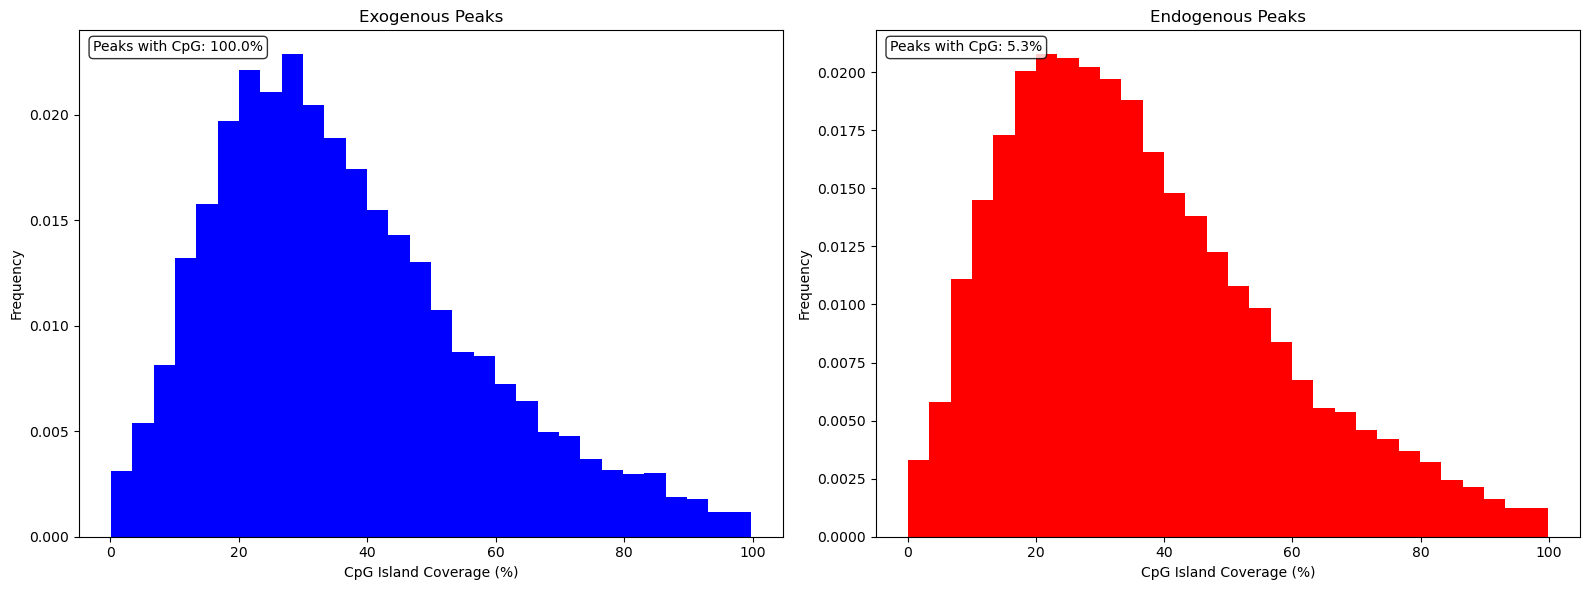

In [22]:
# Create the visualization
plot_coverage_histograms(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=30)

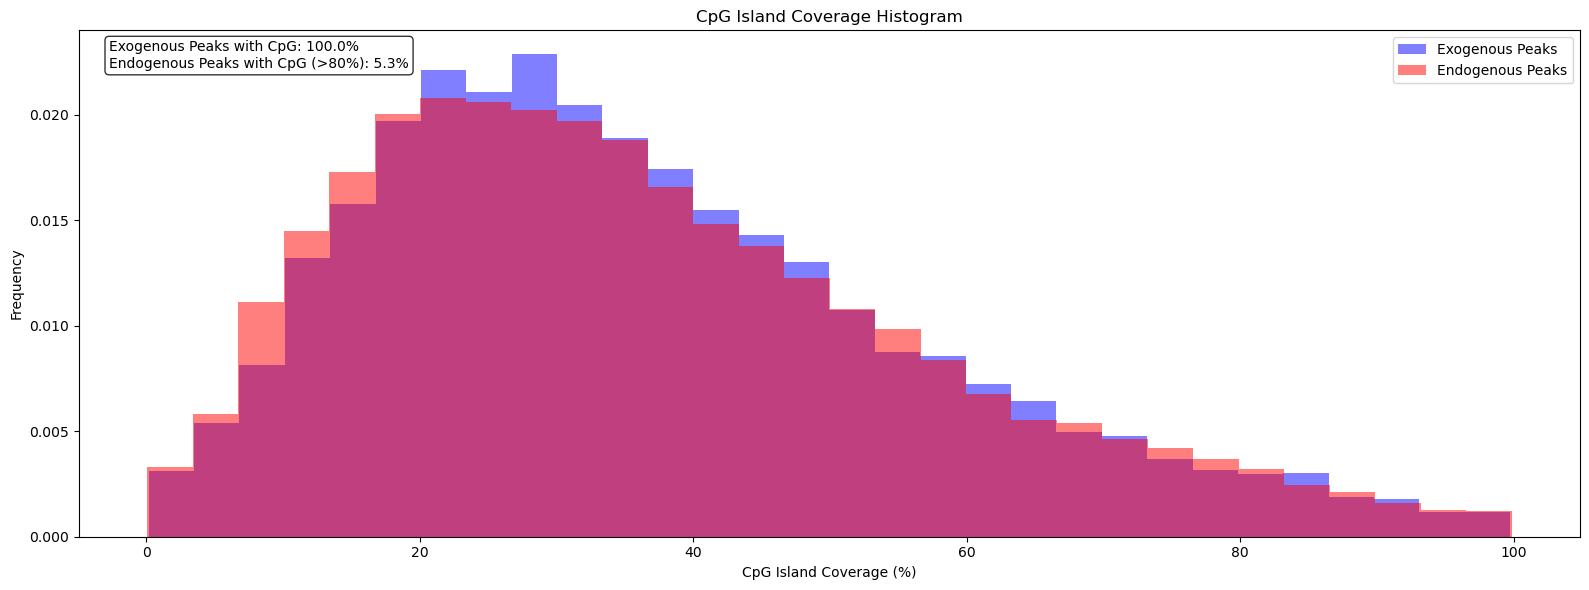

In [21]:
plot_coverage_histograms_overlayed(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=30)

In [53]:
# Save the lists to files
with open('exo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_nsc, f)

with open('endo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(endo_coverage_nsc, f)

In [54]:
# Load the lists back
with open('exo_coverage_nsc.pkl', 'rb') as f:
    exo_coverage_nsc = pickle.load(f)

with open('endo_coverage_nsc.pkl', 'rb') as f:
    endo_coverage_nsc = pickle.load(f)

### Per Peak Coverage

In [64]:
%%capture
exo_coverage_nsc = []
for peak_file in exo_samples_nsc['Peaks']:
    try:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks
        peak_coverages = calculate_peak_cpg_coverage_per_peak(temp_peak, cpg_file, extend=100)
        
        # Extract coverage values, using 0.0 for peaks with no CpG overlap
        coverage_values = [info['max_coverage'] for info in peak_coverages.values()]
        exo_coverage_nsc.extend(coverage_values)
        
        # Clean up
        subprocess.run("rm temp_filtered_peaks.bed", shell=True)
        
    except Exception as e:
        print(f"Error processing {peak_file}: {str(e)}")
        continue

Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 17480/17536 peaks (99.7%)
Error with bedtools slop: * Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *

Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 21347/21437 peaks (99.6%)
Error with bedtools slop: * Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *

Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 15644/15676 peaks (99.8%)
Error with bedtools slop: * Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *



In [66]:
exo_coverage_nsc[:10]


[21.923743500866554,
 65.18847006651885,
 60.128205128205124,
 45.5188679245283,
 22.58064516129032,
 78.8679245283019,
 41.23456790123457,
 18.78367975365666,
 7.12890625,
 21.923828125]

In [68]:
%%capture
endo_coverage_nsc = []
for peak_file in endo_samples_nsc['Peaks']:
    try:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks
        peak_coverages = calculate_peak_cpg_coverage_per_peak(temp_peak, cpg_file, extend=100)
        
        # Extract coverage values, using 0.0 for peaks with no CpG overlap
        coverage_values = [info['max_coverage'] for info in peak_coverages.values()]
        endo_coverage_nsc.extend(coverage_values)
        
        # Clean up
        subprocess.run("rm temp_filtered_peaks.bed", shell=True)
    except Exception as e:
        print(f"Error processing {peak_file}: {str(e)}")
        continue

In [69]:
endo_coverage_nsc[:10]

[17.330677290836654,
 74.65753424657534,
 24.264705882352942,
 51.70893054024256,
 11.438474870017332,
 65.5210643015521,
 78.84615384615384,
 62.02830188679245,
 15.415415415415415,
 33.533533533533536]

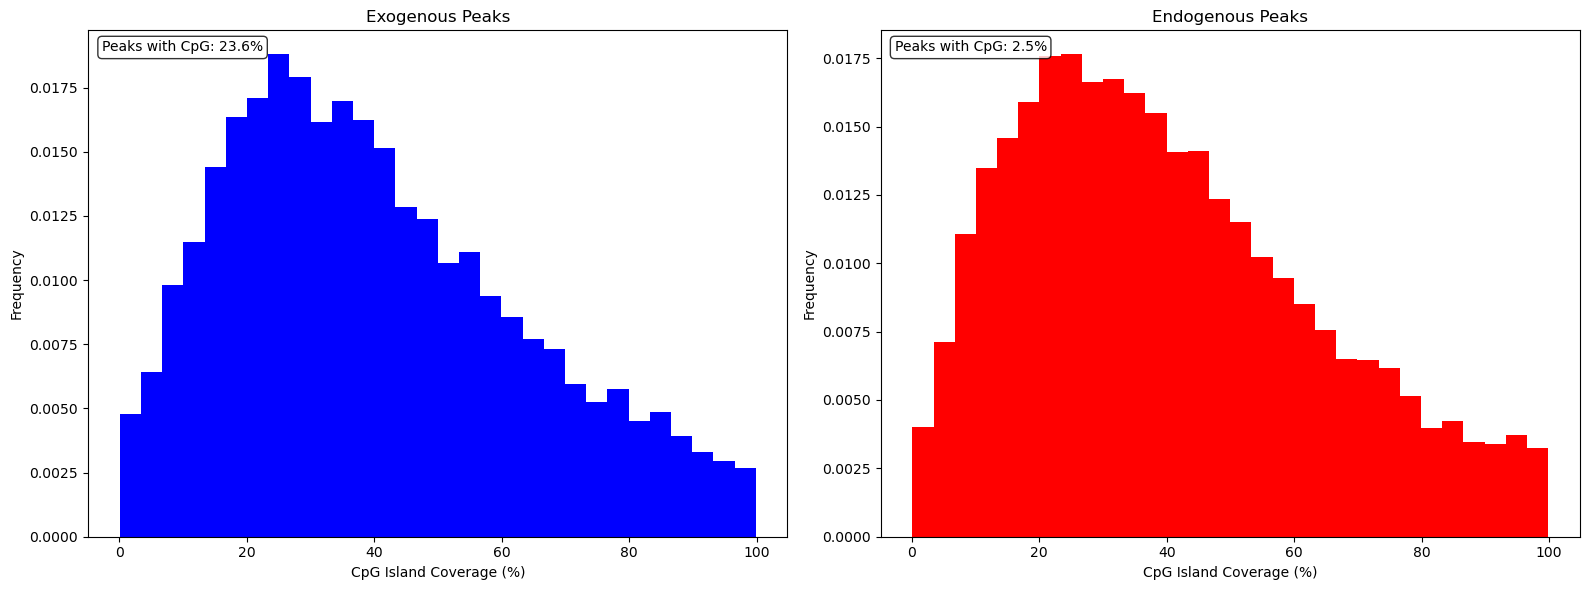

In [71]:
# Create the visualization
plot_coverage_histograms(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=30)

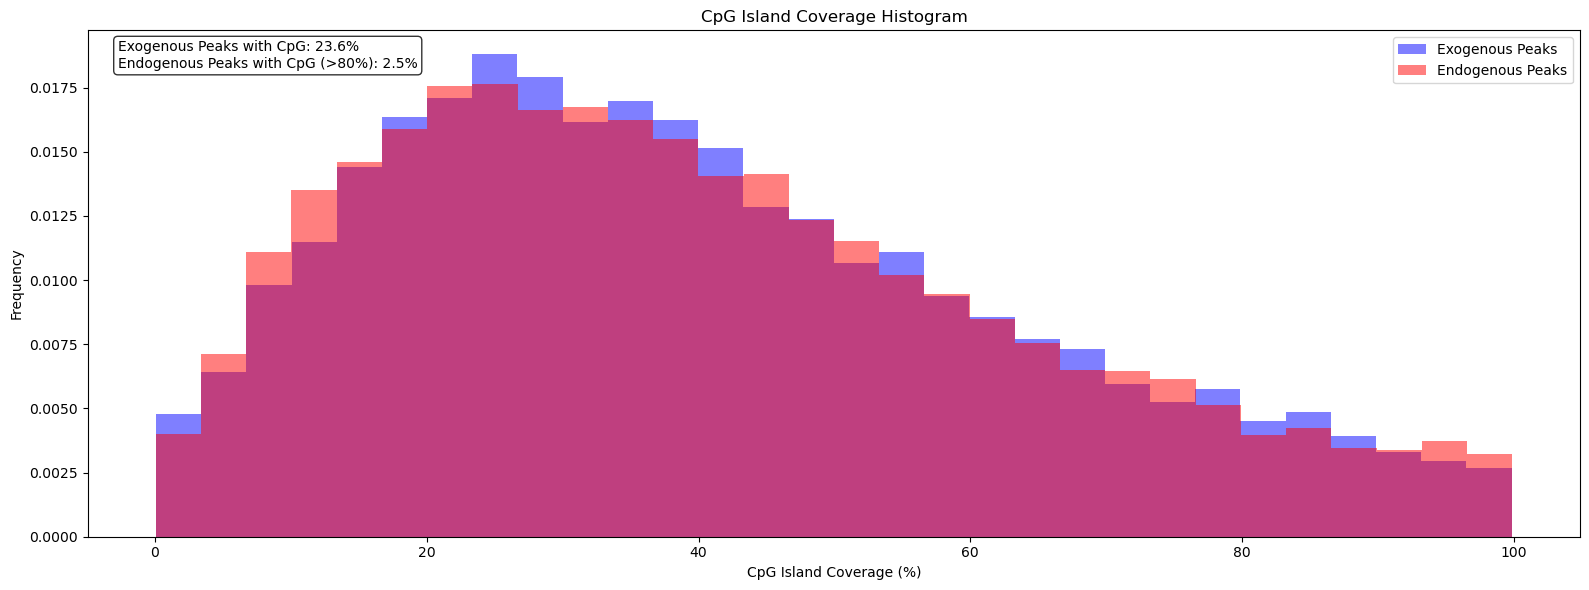

In [72]:
plot_coverage_histograms_overlayed(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=30)

## Neurons


In [173]:
exo_coverage_neurons = []
for peak_file in exo_samples_neurons['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    exo_coverage_neurons.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)



Filtered results/peaks/NeuV1_peaks.narrowPeak: kept 56178/56234 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Filtered results/peaks/NeuV2_peaks.narrowPeak: kept 71591/71695 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Filtered results/peaks/NeuV3_peaks.narrowPeak: kept 77234/77302 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [174]:
exo_coverage_neurons[:10]

[0.0, 0.0, 0.0, 0.0, 88.43537414965986, 100.0, 100.0, 0.0, 0.0, 0.0]

In [175]:
%%capture
endo_coverage_neurons = []

# First filter the CpG file once (no need to do it for each peak file)
temp_cpg = "temp_filtered_cpg.bed"
filter_standard_chromosomes(cpg_file, temp_cpg)

try:
    # Process each peak file
    for peak_file in endo_samples_nsc['Peaks']:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks and filtered CpG file
        coverage = calculate_peak_cpg_coverage(temp_peak, temp_cpg, extend=100)
        endo_coverage_neurons.extend(coverage)
        
        # Clean up peak file
        if os.path.exists(temp_peak):
            os.remove(temp_peak)
finally:
    # Clean up CpG file
    if os.path.exists(temp_cpg):
        os.remove(temp_cpg)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [176]:
endo_coverage_neurons[:10]


[0.0,
 0.0,
 0.0,
 90.27237354085604,
 0.0,
 93.02721088435374,
 100.0,
 100.0,
 100.0,
 0.0]

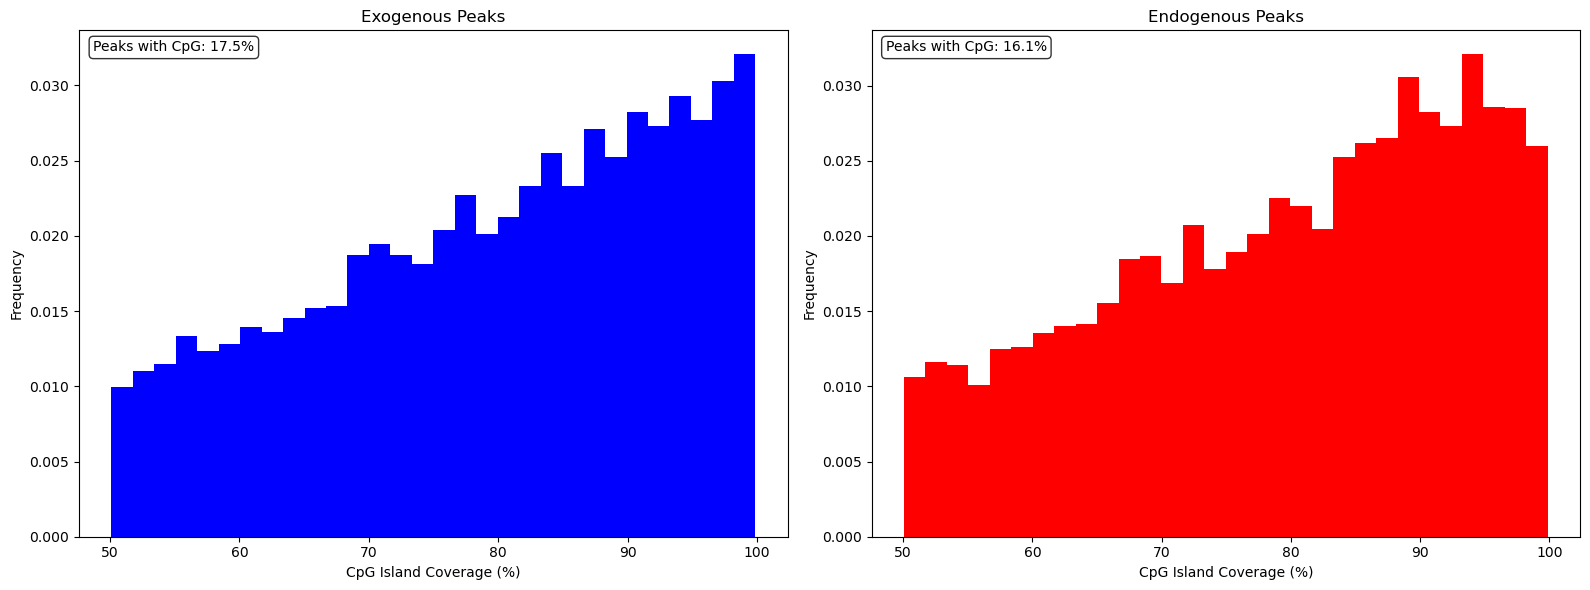

In [177]:
# Create the visualization
plot_coverage_histograms(exo_coverage_neurons, endo_coverage_neurons, min_coverage=50, n_bins=30)

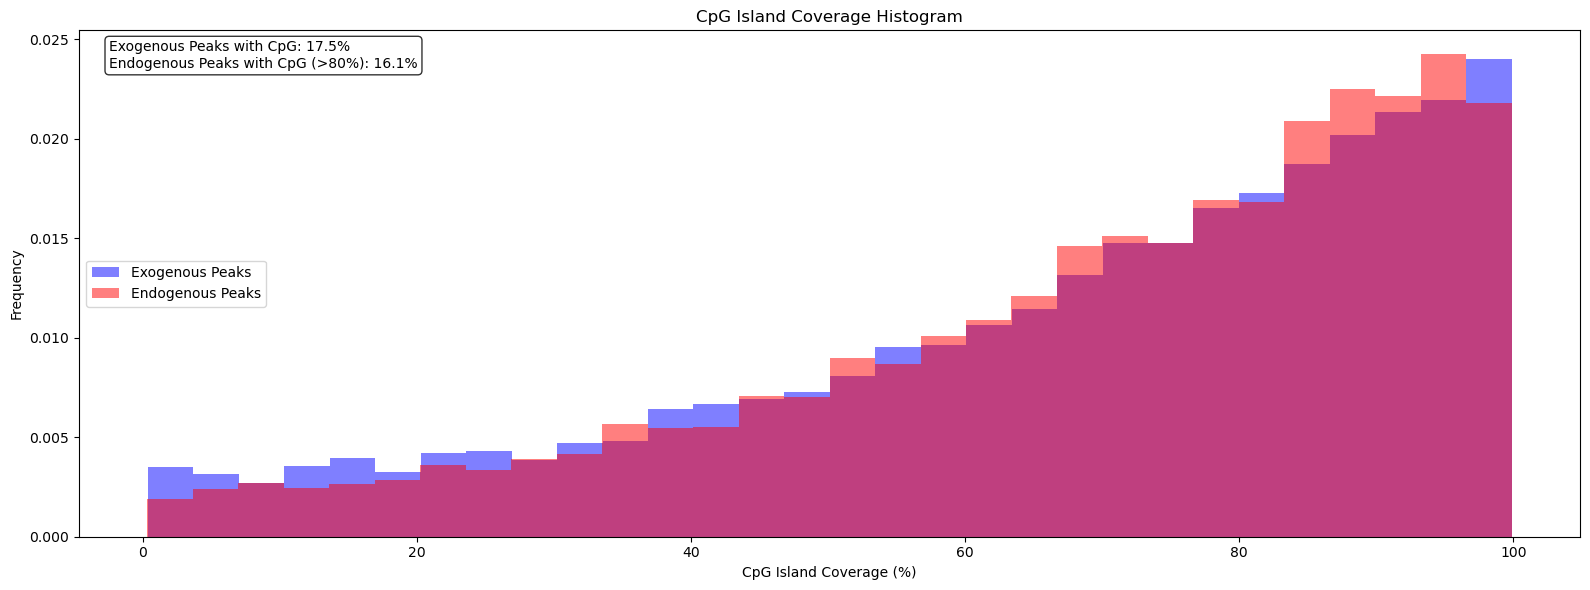

In [178]:
plot_coverage_histograms_overlayed(exo_coverage_neurons, endo_coverage_neurons, min_coverage=0, n_bins=30)

In [179]:
# Save the lists to files
with open('exo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_neurons, f)

with open('endo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(endo_coverage_neurons, f)

In [180]:

# Load the lists back
with open('exo_coverage_neurons.pkl', 'rb') as f:
    exo_coverage_neurons = pickle.load(f)

with open('endo_coverage_neurons.pkl', 'rb') as f:
    endo_coverage_nsc = pickle.load(f)

# Only with the common peaks

### NSC


In [181]:
# Read the gene list
genes_df_nsc = pd.read_csv("DATA/allgenes_NSC_total.csv")

# Filter for genes that have both types of promoters
common_genes_nsc = genes_df_nsc[
    (genes_df_nsc['Endogenous_Promoter'] == True) & 
    (genes_df_nsc['Exogenous_Promoter'] == True)
]
print(f"Number of genes with both promoter types: {len(common_genes_nsc)}")
print("Example genes:", common_genes_nsc['gene'].head().tolist())

Number of genes with both promoter types: 2231
Example genes: ['Aak1', 'Abat', 'Abca1', 'Abca3', 'Abca4']


In [182]:
common_genes_nsc.head()


,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Aak1,9040.147360,0.523064,UP,True,True
2,Abat,2381.129589,1.737878,UP,True,True
3,Abca1,1217.144188,2.799356,UP,True,True
5,Abca3,1274.604870,1.025460,UP,True,True
6,Abca4,107.938485,-1.498484,DOWN,True,True


In [183]:
# %%capture
exo_coverage_nsc = []

# First filter the CpG file once (no need to do it for each peak file)
temp_cpg = "temp_filtered_cpg.bed"
filter_standard_chromosomes(cpg_file, temp_cpg)

try:
    # Process each peak file
    for peak_file in exo_samples_nsc['Peaks']:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks and filtered CpG file
        coverage = calculate_peak_cpg_coverage(temp_peak, temp_cpg, extend=100)
        exo_coverage_nsc.extend(coverage)
        
        # Clean up peak file
        if os.path.exists(temp_peak):
            os.remove(temp_peak)
finally:
    # Clean up CpG file
    if os.path.exists(temp_cpg):
        os.remove(temp_cpg)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [184]:
exo_coverage_nsc[:10]


[100.0, 100.0, 0.0, 0.0, 0.0, 0.0, 100.0, 100.0, 100.0, 0.0]

In [185]:
# %%capture
endo_coverage_nsc = []

# First filter the CpG file once (no need to do it for each peak file)
temp_cpg = "temp_filtered_cpg.bed"
filter_standard_chromosomes(cpg_file, temp_cpg)

try:
    # Process each peak file
    for peak_file in endo_samples_nsc['Peaks']:
        # Create temporary filtered peak file
        temp_peak = "temp_filtered_peaks.bed"
        filter_standard_chromosomes(peak_file, temp_peak)
        
        # Calculate coverage using filtered peaks and filtered CpG file
        coverage = calculate_peak_cpg_coverage(temp_peak, temp_cpg, extend=100)
        endo_coverage_nsc.extend(coverage)
        
        # Clean up peak file
        if os.path.exists(temp_peak):
            os.remove(temp_peak)
finally:
    # Clean up CpG file
    if os.path.exists(temp_cpg):
        os.remove(temp_cpg)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


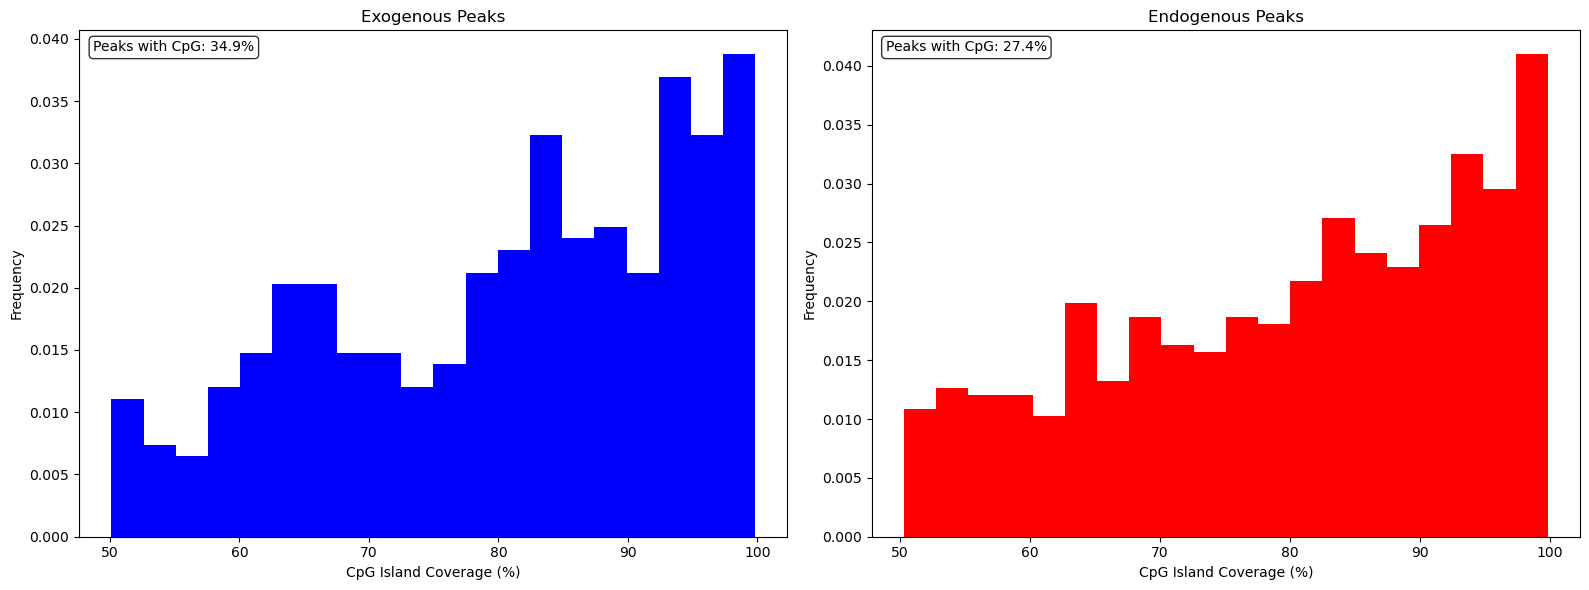

In [186]:
# Create the visualization
plot_coverage_histograms(exo_coverage_nsc, endo_coverage_nsc, min_coverage=50, n_bins=20)

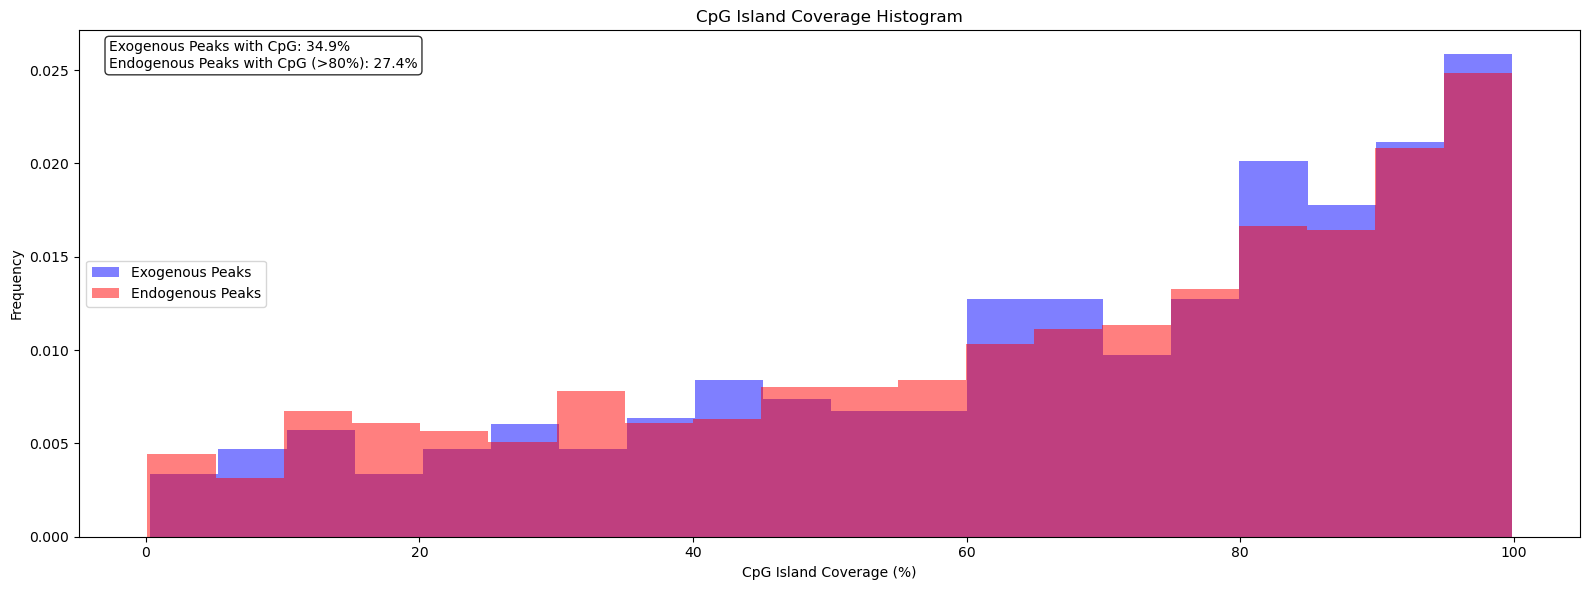

In [187]:
plot_coverage_histograms_overlayed(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=20)

In [188]:
# Save the lists to files
with open('selected_exo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_nsc, f)

with open('selected_endo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(endo_coverage_nsc, f)

In [189]:
# Load the lists back
with open('selected_exo_coverage_nsc.pkl', 'rb') as f:
    exo_coverage_nsc = pickle.load(f)

with open('selected_endo_coverage_nsc.pkl', 'rb') as f:
    endo_coverage_nsc = pickle.load(f)

### Neurons


In [190]:
# Read the gene list
genes_df_neurons = pd.read_csv("DATA/allgenes_NEU_total.csv")

# Filter for genes that have both types of promoters
common_genes_neurons = genes_df_neurons[
    (genes_df_neurons['Endogenous_Promoter'] == True) & 
    (genes_df_neurons['Exogenous_Promoter'] == True)
]
print(f"Number of genes with both promoter types: {len(common_genes_neurons)}")
print("Example genes:", common_genes_neurons['gene'].head().tolist())

Number of genes with both promoter types: 285
Example genes: ['Abcc4', 'Adamts10', 'Adamtsl2', 'Adgrl2', 'Adrb1']


In [191]:
%%capture
exo_coverage_neurons = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes_neurons, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_neurons.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [192]:
%%capture
endo_coverage_neurons = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes_neurons, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file)
    endo_coverage_neurons.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


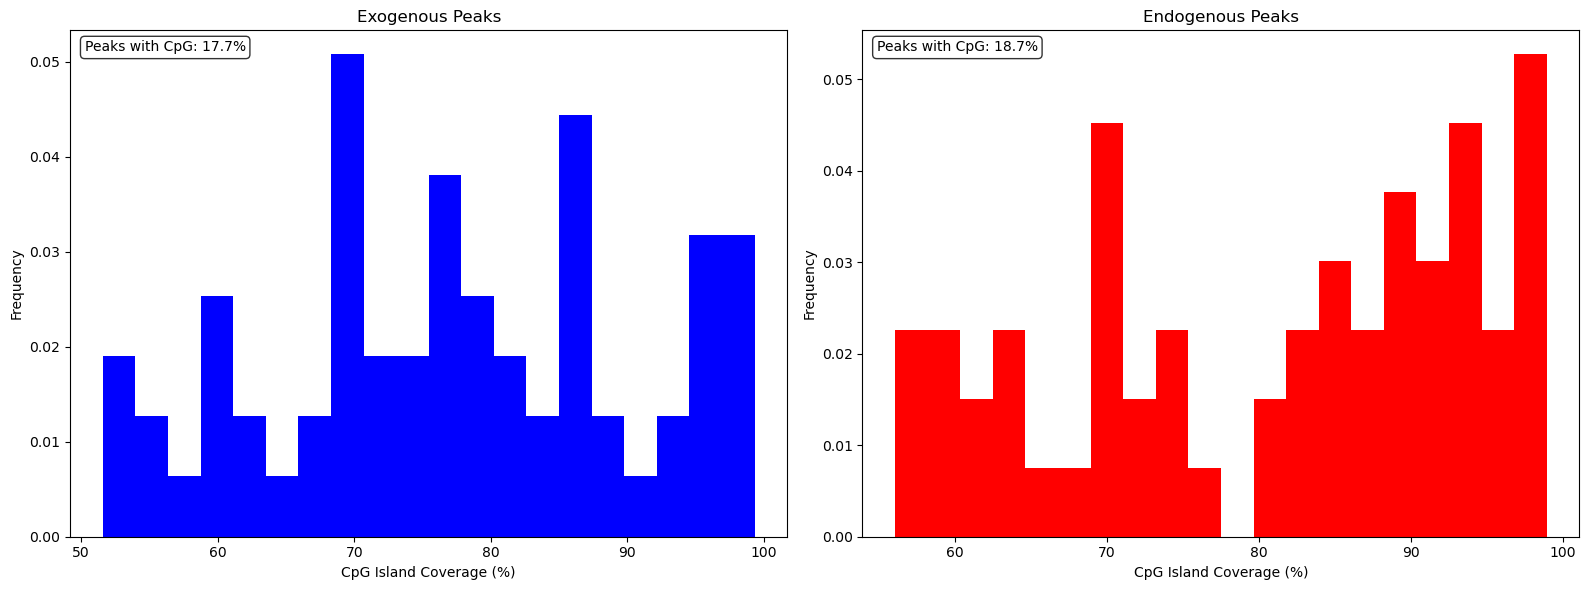

In [193]:
plot_coverage_histograms(exo_coverage_neurons, endo_coverage_neurons, min_coverage=50, n_bins=20)

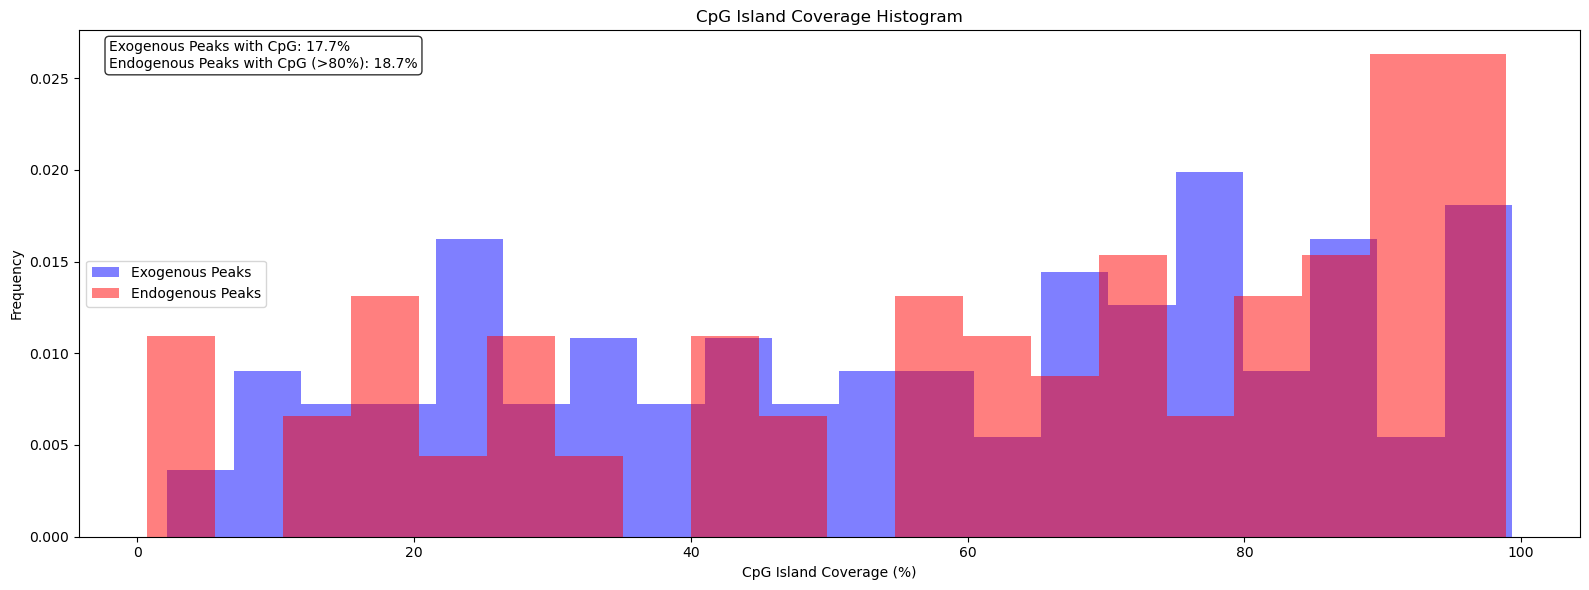

In [194]:
plot_coverage_histograms_overlayed(exo_coverage_neurons, endo_coverage_neurons, min_coverage=0, n_bins=20)


In [195]:
# Save the lists to files
with open('selected_exo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_neurons, f)

with open('selected_endo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(endo_coverage_neurons, f)

In [196]:

# Load the lists back
with open('selected_exo_coverage_neurons.pkl', 'rb') as f:
    exo_coverage_neurons = pickle.load(f)

with open('selected_endo_coverage_neurons.pkl', 'rb') as f:
    endo_coverage_neurons = pickle.load(f)

# DE expression bins

In [197]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [198]:
DEA_NSC.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,Mir5125,128.824113,0.000073,0.189117,0.000383,0.999694,0.999694
1,Trim68,98.639563,0.000133,0.215486,0.000617,0.999508,0.999614
2,Frrs1,442.946120,0.000097,0.109825,0.000883,0.999295,0.999556
3,Notch4,60.968185,0.000246,0.266300,0.000925,0.999262,0.999556
4,Ano6,5982.860518,0.000074,0.070708,0.001043,0.999168,0.999503


In [199]:
# Calculate quantiles and assign expression levels
q33_, q66_ = DEA_NSC['baseMean'].quantile([0.33, 0.66])
DEA_NSC['expression_level'] = DEA_NSC['baseMean'].apply(lambda x: get_expression_level(x, q33_, q66_))

q33, q66 = DEA_NEU['baseMean'].quantile([0.33, 0.66])
DEA_NEU['expression_level'] = DEA_NEU['baseMean'].apply(lambda x: get_expression_level(x, q33, q66))

## UP

In [200]:
DEA_NEU_up = DEA_NEU[(DEA_NEU['padj'] < 0.05) & (DEA_NEU['log2FoldChange'] > 0)]
DEA_NSC_up = DEA_NSC[(DEA_NSC['padj'] < 0.05) & (DEA_NSC['log2FoldChange'] > 0)]

### NSC

In [201]:
# Calculate quantiles for expression binning
# q33, q66 = DEA_NSC_up['baseMean'].quantile([0.33, 0.66])

In [202]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_up['expression_level'].value_counts())

In [203]:
DEA_NSC_up_high = DEA_NSC_up[DEA_NSC_up.expression_level == 'High']
DEA_NSC_up_medium = DEA_NSC_up[DEA_NSC_up.expression_level == 'Medium']
DEA_NSC_up_low = DEA_NSC_up[DEA_NSC_up.expression_level == 'Low']

In [204]:
%%capture
# Calculate coverage for filtered peaks
exo_coverage_up_high = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_up_medium = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)
    
# Calculate coverage for filtered peaks
exo_coverage_up_low = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [205]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_up_high = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_medium = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_low = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


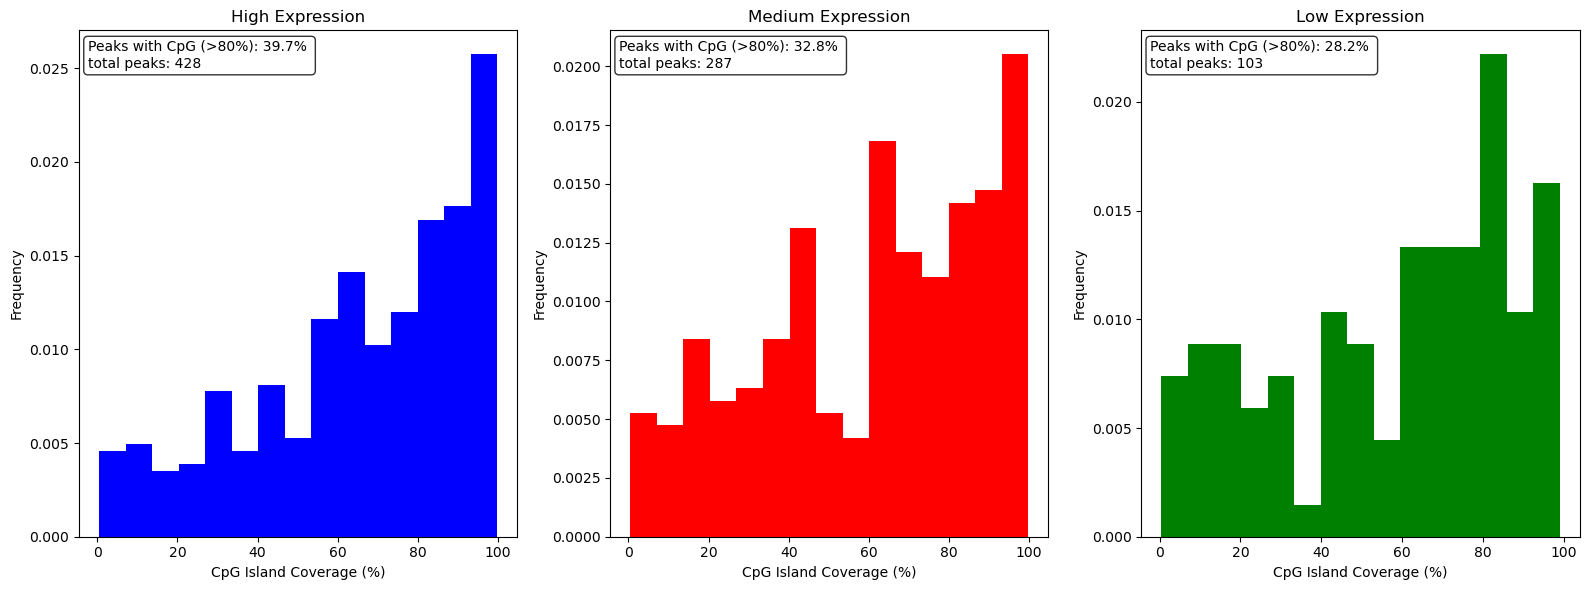

In [206]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_up_high, exo_coverage_up_medium, exo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


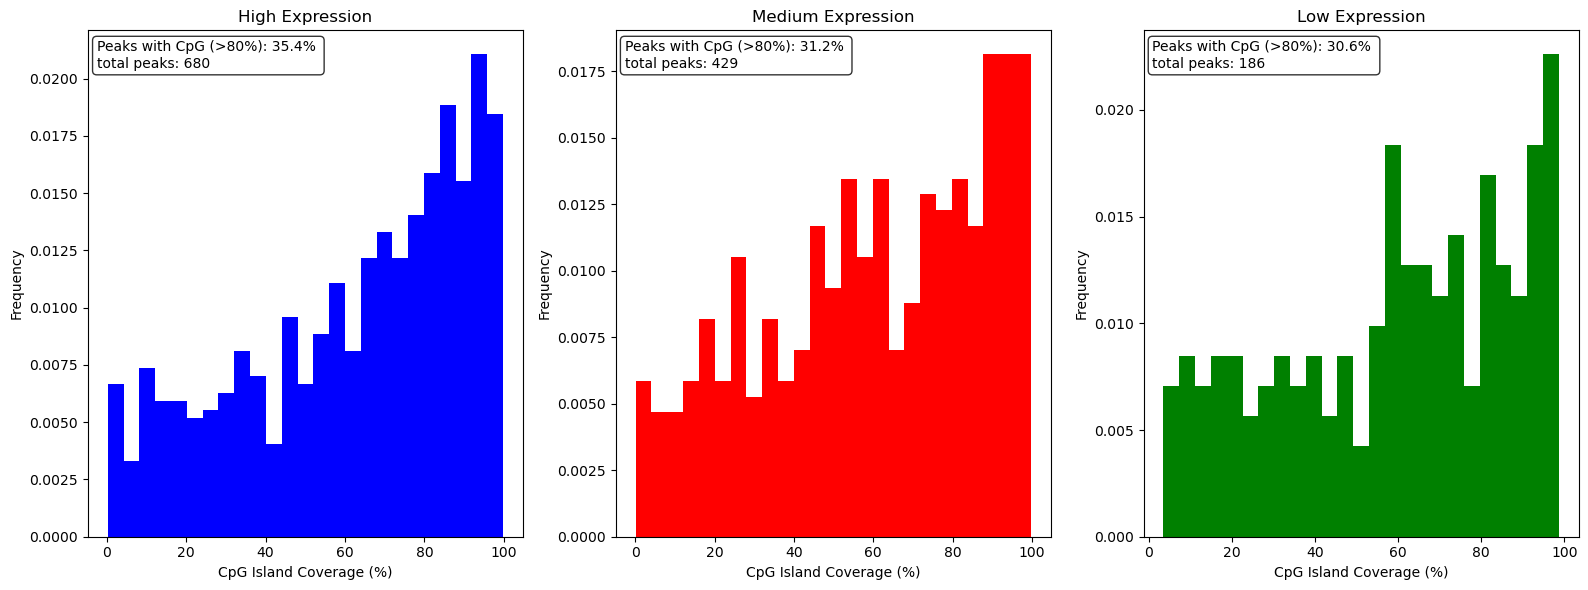

In [207]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_up_high, endo_coverage_up_medium, endo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=25)
plt.show()


In [208]:
# Save the lists to files
with open('expression_coverage_up_high_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_high, f)

with open('expression_coverage_up_medium_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_medium, f)

with open('expression_coverage_up_low_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_low, f)



### Neurons


In [209]:
# Calculate quantiles for expression binning
# q33, q66 = DEA_NEU_up['baseMean'].quantile([0.33, 0.66])

In [210]:
%%capture
#  Add expression level column to DEA_NSC
DEA_NEU_up['expression_level'] = DEA_NEU_up['baseMean'].apply(lambda x: get_expression_level(x, q33_, q66_))

In [211]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_up['expression_level'].value_counts())

In [212]:
DEA_NEU_up_high = DEA_NEU_up[DEA_NEU_up.expression_level == 'High']
DEA_NEU_up_medium = DEA_NEU_up[DEA_NEU_up.expression_level == 'Medium']
DEA_NEU_up_low = DEA_NEU_up[DEA_NEU_up.expression_level == 'Low']

In [213]:
%%capture
# Calculate coverage for filtered peaks
exo_coverage_up_high = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_up_medium = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)
    
# Calculate coverage for filtered peaks
exo_coverage_up_low = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [214]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_up_high = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_medium = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_low = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


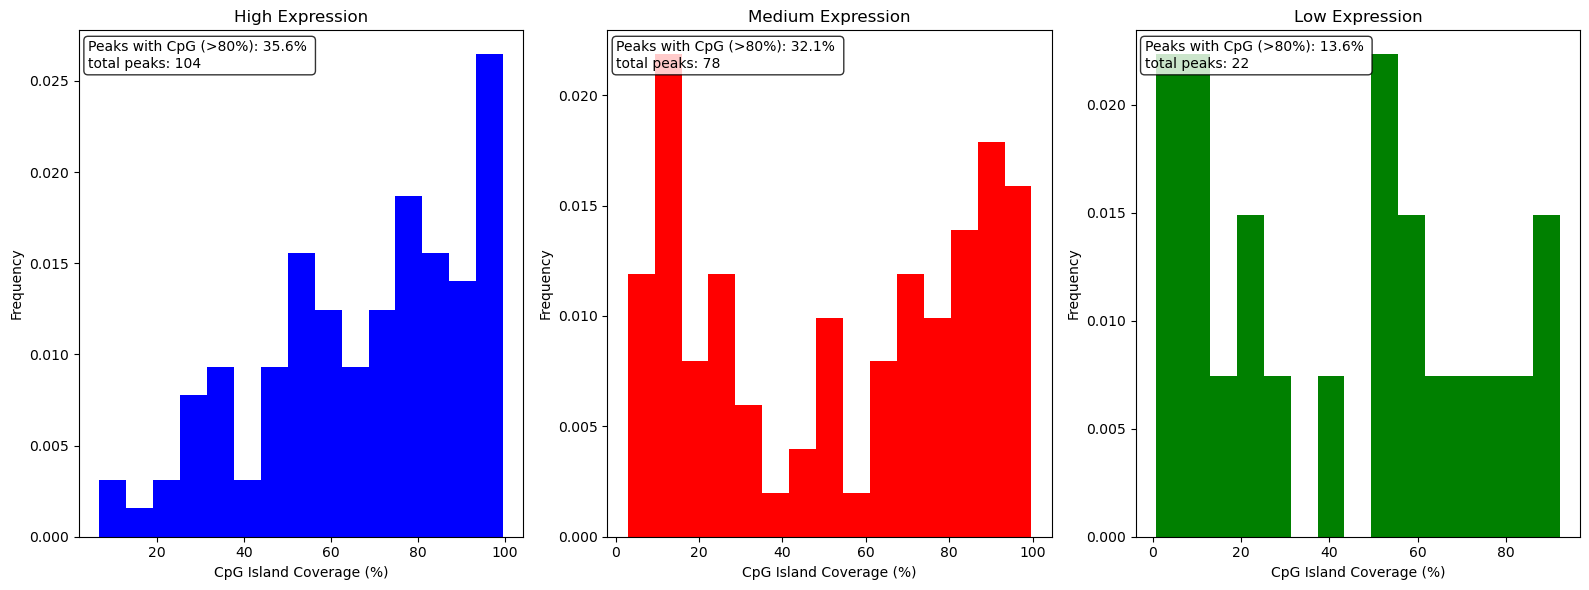

In [215]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_up_high, exo_coverage_up_medium, exo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


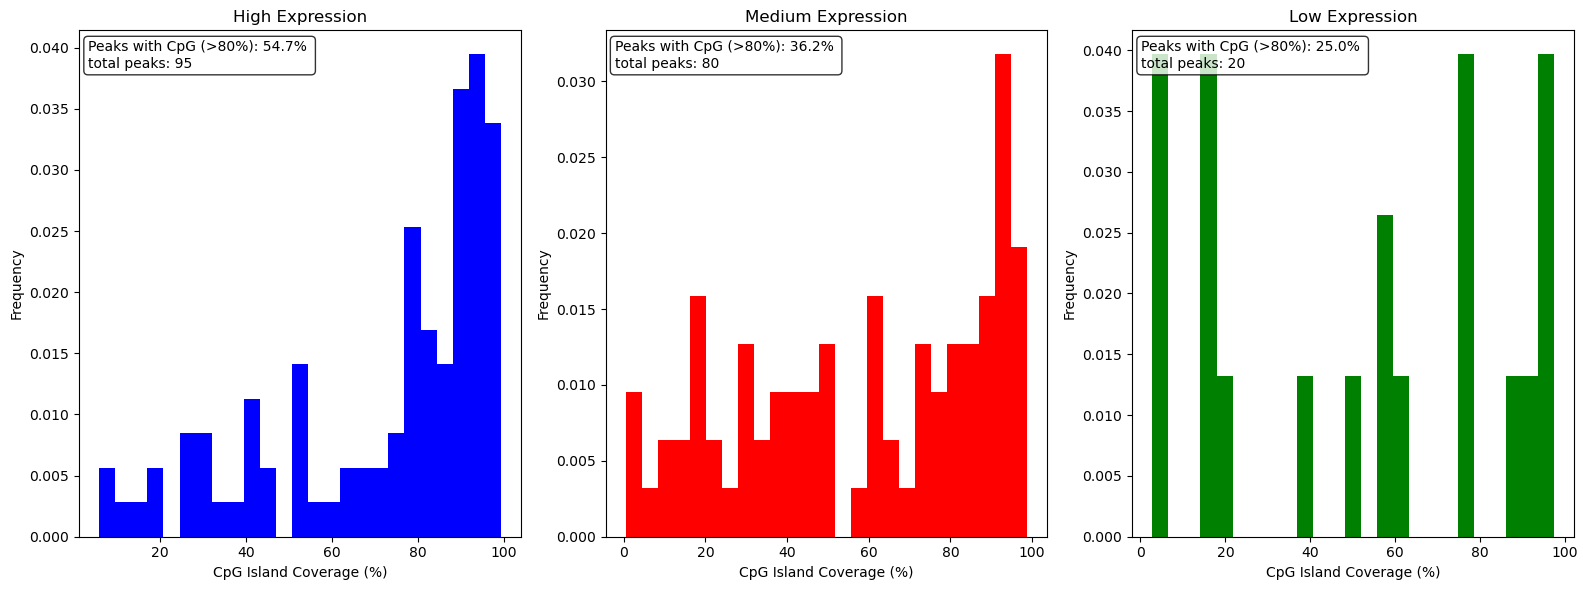

In [216]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_up_high, endo_coverage_up_medium, endo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=25)
plt.show()


In [217]:
# Save the lists to files
with open('expression_coverage_up_high_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_high, f)

with open('expression_coverage_up_medium_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_medium, f)

with open('expression_coverage_up_low_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_low, f)

## Down

In [218]:
DEA_NEU_down = DEA_NEU[(DEA_NEU['padj'] < 0.05) & (DEA_NEU['log2FoldChange'] < 0)]
DEA_NSC_down = DEA_NSC[(DEA_NSC['padj'] < 0.05) & (DEA_NSC['log2FoldChange'] < 0)]

### NSC


In [219]:
# # Calculate quantiles for expression binning
# q33, q66 = DEA_NSC_down['baseMean'].quantile([0.33, 0.66])

In [220]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_down['expression_level'].value_counts())

In [221]:
DEA_NSC_down_high = DEA_NSC_down[DEA_NSC_down.expression_level == 'High']
DEA_NSC_down_medium = DEA_NSC_down[DEA_NSC_down.expression_level == 'Medium']
DEA_NSC_down_low = DEA_NSC_down[DEA_NSC_down.expression_level == 'Low']

In [222]:
%%capture
exo_coverage_down_high = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_medium = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_low = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [223]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_down_high = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_medium = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_low = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


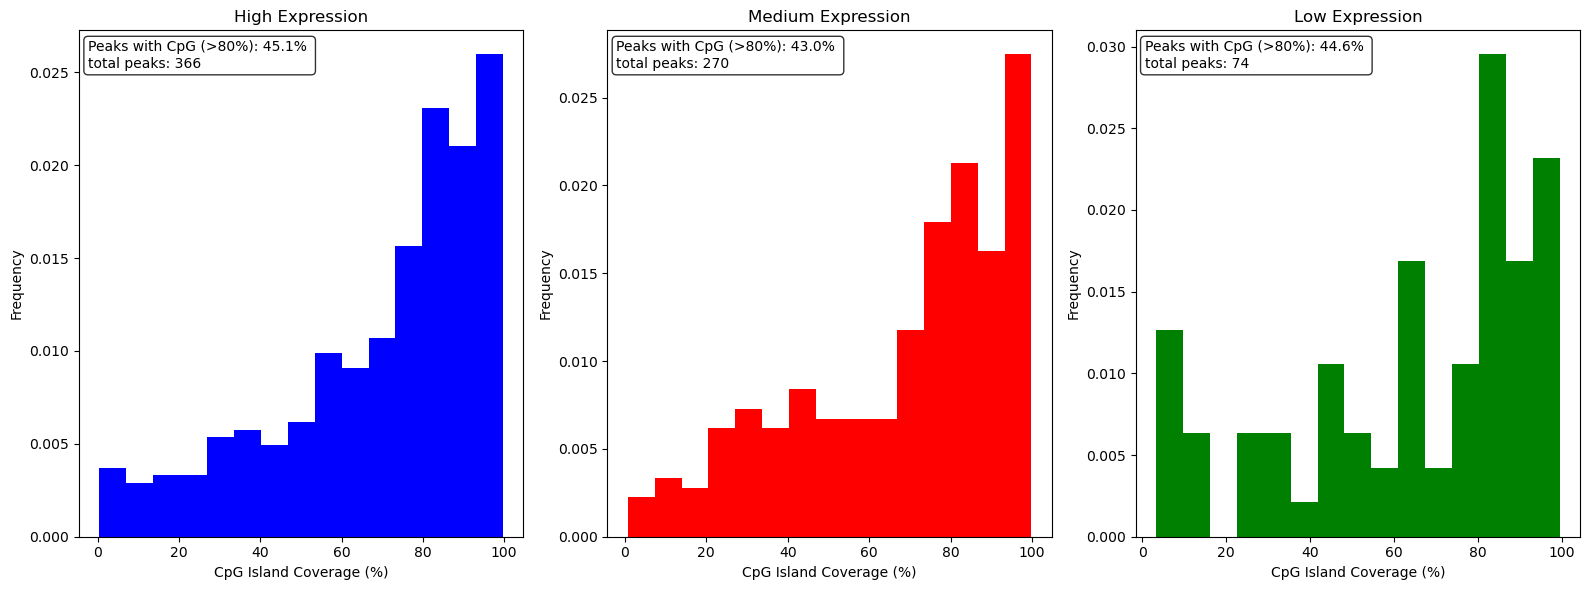

In [224]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_down_high, exo_coverage_down_medium, exo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


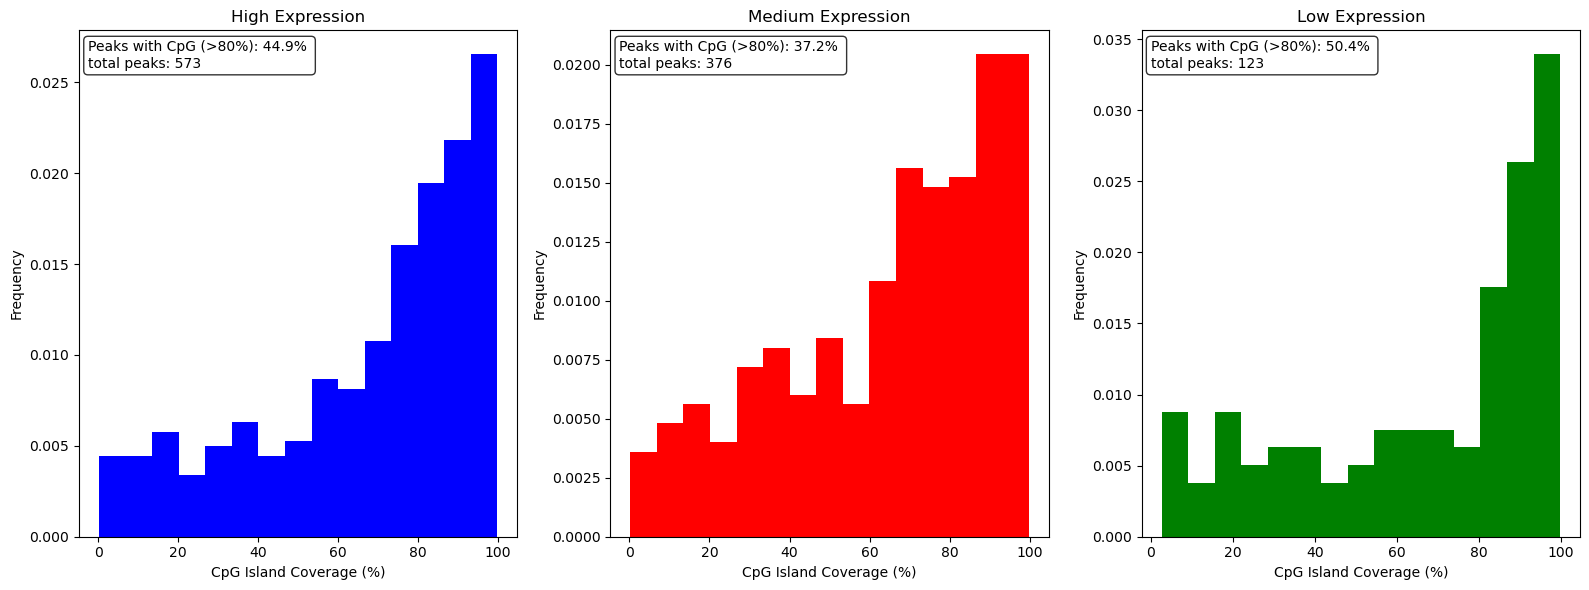

In [225]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_down_high, endo_coverage_down_medium, endo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


### Neurons

In [226]:
# # Calculate quantiles for expression binning
# q33, q66 = DEA_NEU_down['baseMean'].quantile([0.33, 0.66])


In [227]:
# Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NEU_down['expression_level'].value_counts())

DEA_NEU_down_high = DEA_NEU_down[DEA_NEU_down.expression_level == 'High']
DEA_NEU_down_medium = DEA_NEU_down[DEA_NEU_down.expression_level == 'Medium']
DEA_NEU_down_low = DEA_NEU_down[DEA_NEU_down.expression_level == 'Low']

In [228]:
%%capture
exo_coverage_down_high = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_medium = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_low = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [229]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_down_high = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_medium = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_low = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


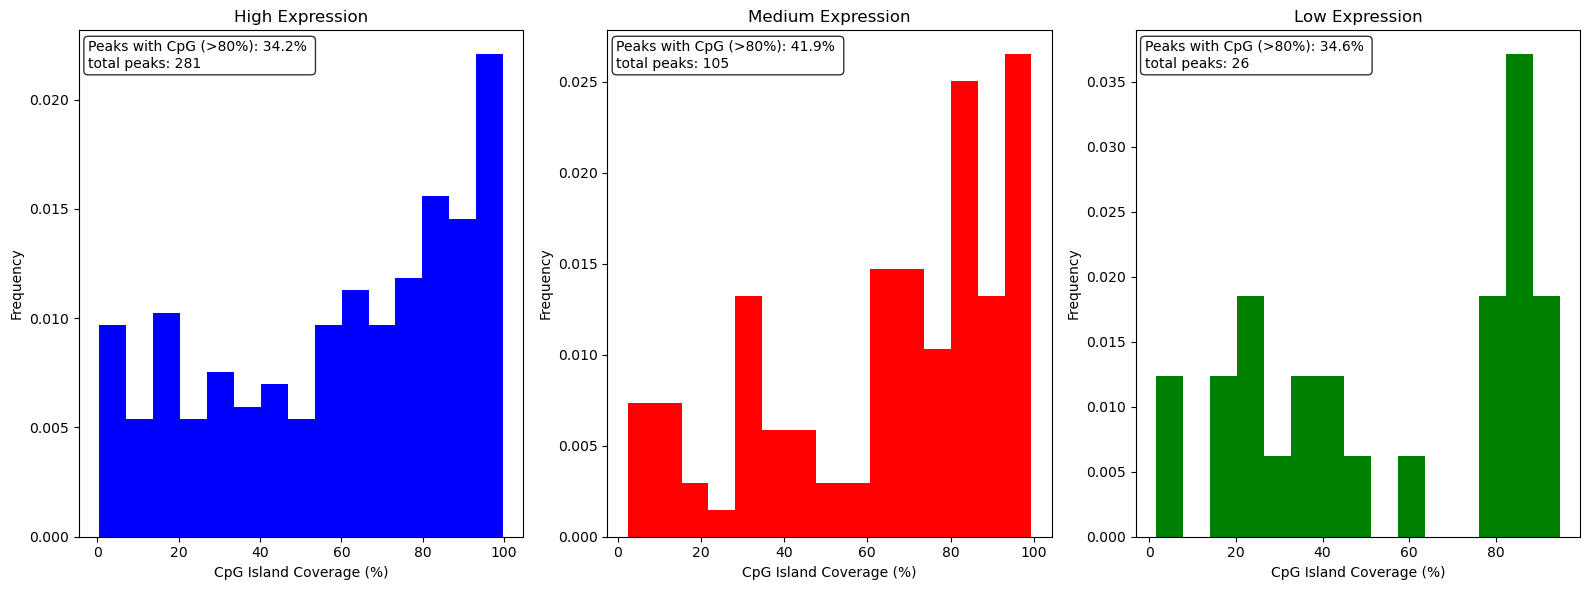

In [230]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_down_high, exo_coverage_down_medium, exo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


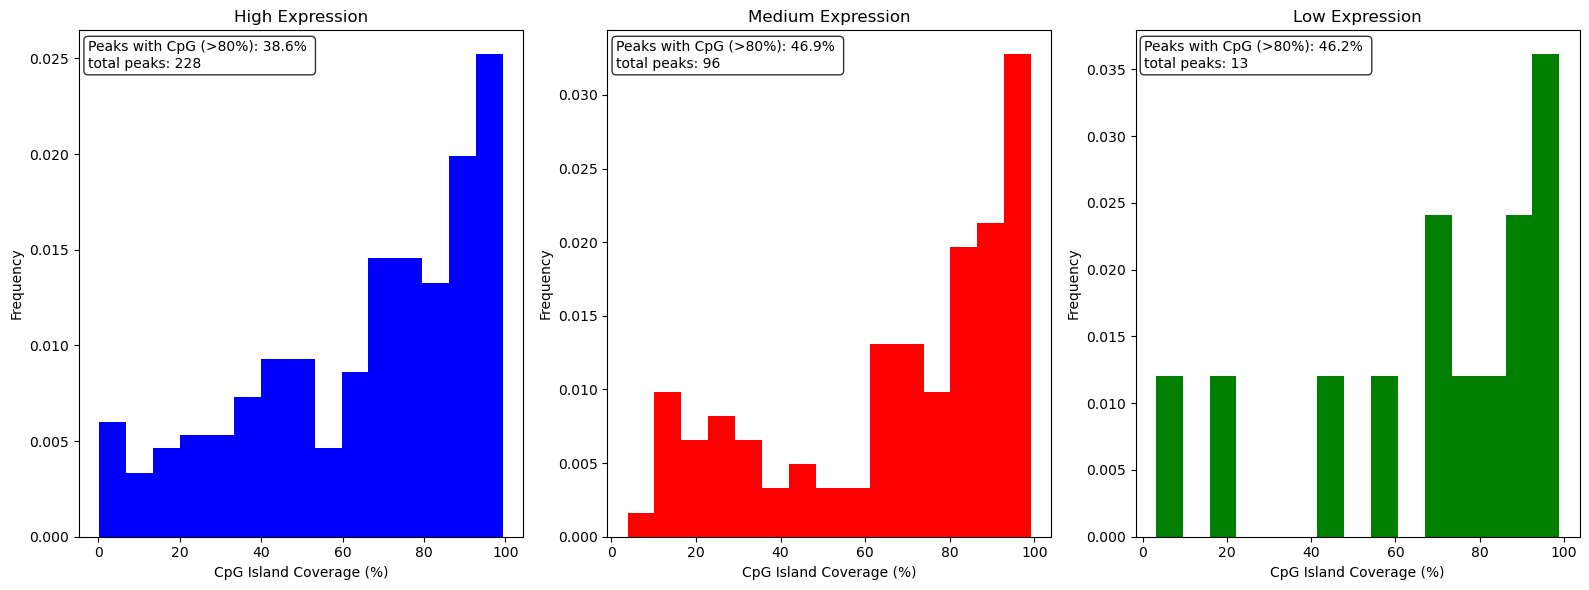

In [231]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_down_high, endo_coverage_down_medium, endo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


## Not DE

### NSC

In [232]:
DEA_NEU_not_de = DEA_NEU[DEA_NEU['padj'] > 0.05]
DEA_NSC_not_de = DEA_NSC[DEA_NSC['padj'] > 0.05]

In [233]:
# Calculate quantiles for expression binning
# q33, q66 = DEA_NSC_not_de['baseMean'].quantile([0.33, 0.66])

In [234]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_not_de['expression_level'].value_counts())

In [235]:
DEA_NSC_not_de_high = DEA_NSC_not_de[DEA_NSC_not_de.expression_level == 'High']
DEA_NSC_not_de_medium = DEA_NSC_not_de[DEA_NSC_not_de.expression_level == 'Medium']
DEA_NSC_not_de_low = DEA_NSC_not_de[DEA_NSC_not_de.expression_level == 'Low']

In [236]:
%%capture
exo_coverage_not_de_high = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_not_de_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_not_de_medium = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_not_de_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_not_de_low = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_not_de_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [237]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_not_de_high = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_not_de_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_not_de_medium = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_not_de_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_not_de_low = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_not_de_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


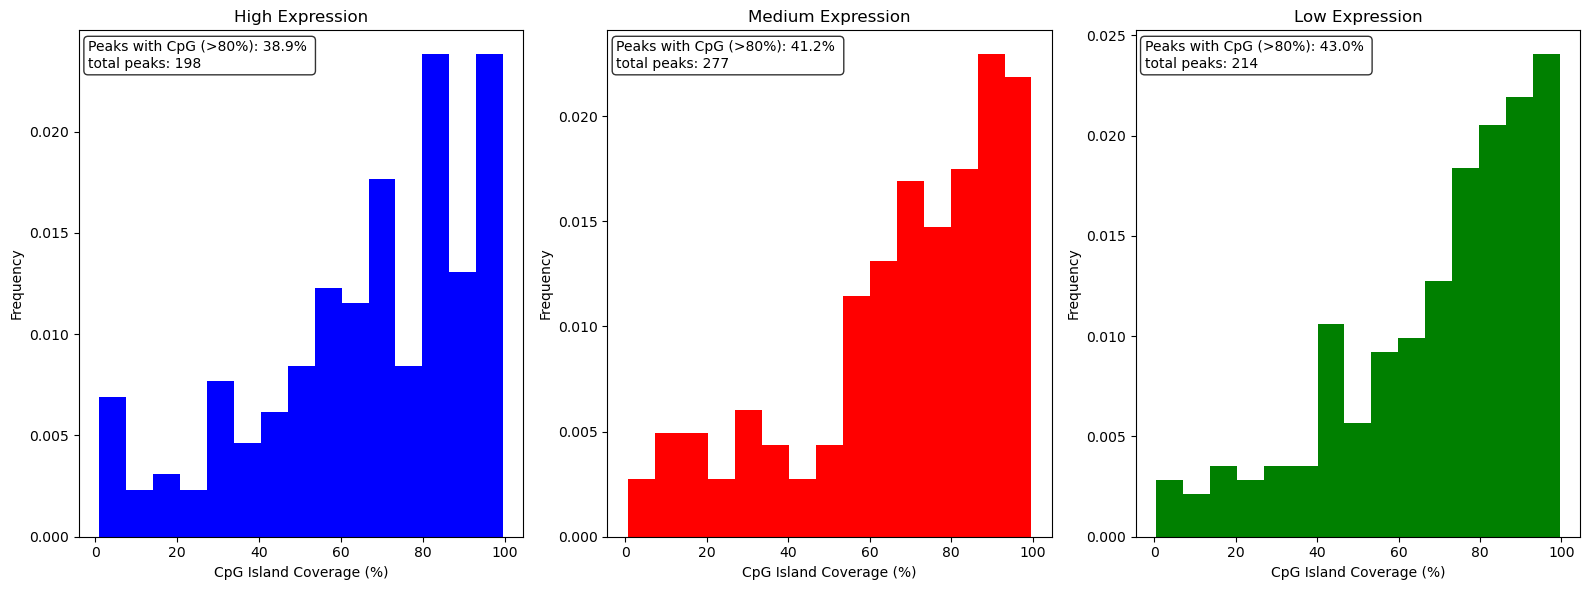

In [238]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_not_de_high, exo_coverage_not_de_medium, exo_coverage_not_de_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


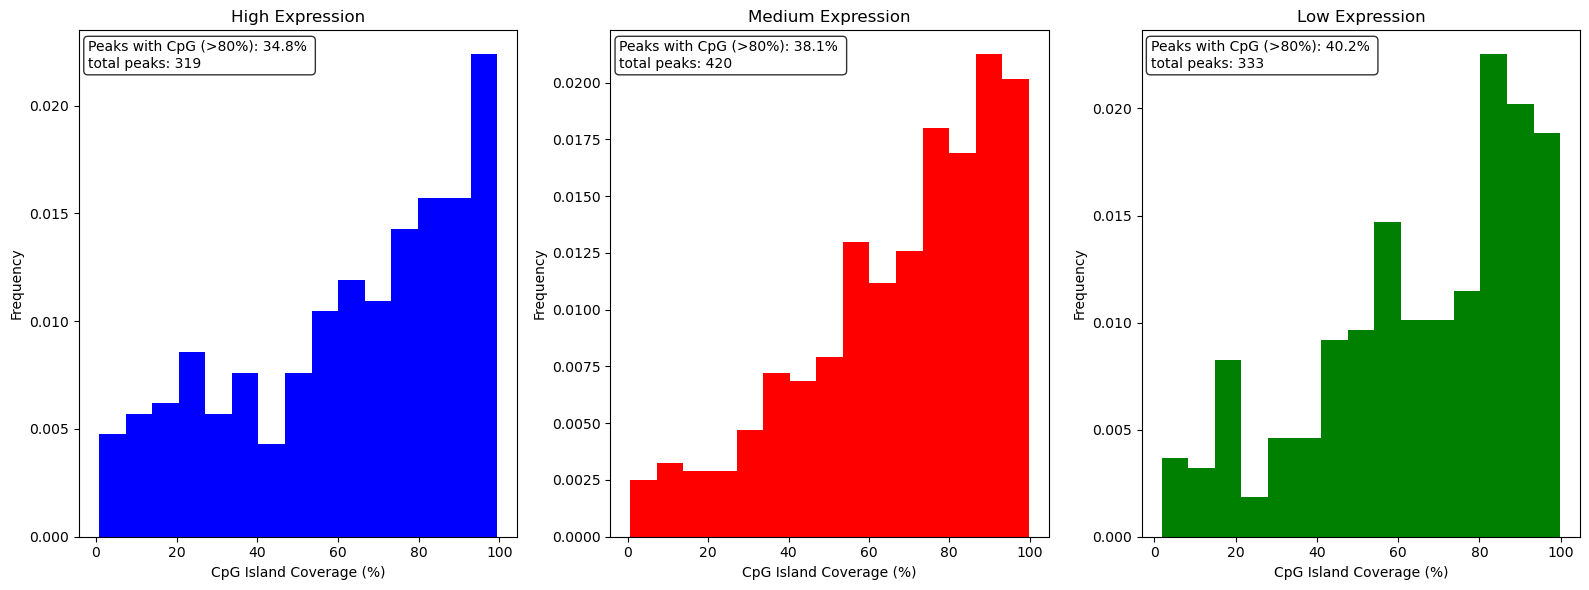

In [239]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_not_de_high, endo_coverage_not_de_medium, endo_coverage_not_de_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


# Plot peaks signals

In [240]:
import gzip
import numpy as np

def plot_peak_signals(peak_file, bigwig_files, window_size=1000, num_peaks=5):
    """
    Plot signal profiles for selected peaks across multiple bigWig files
    """
    import gzip  # Add this import at the top
    
    # Select random peaks
    cmd = f"shuf -n {num_peaks} {peak_file} > temp_random_peaks.bed"
    subprocess.run(cmd, shell=True)
    
    # Center peaks and extend by window_size
    half_window = window_size // 2
    signals = {}
    
    for bw_file in bigwig_files:
        # Use deepTools computeMatrix to get signal values
        matrix_file = "temp_matrix.gz"
        cmd = (f"computeMatrix reference-point"
               f" --referencePoint center"
               f" -b {half_window} -a {half_window}"
               f" -R temp_random_peaks.bed"
               f" -S {bw_file}"
               f" --skipZeros"
               f" -o {matrix_file}")
        
        # Run command and check for errors
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error running computeMatrix for {bw_file}:")
            print(result.stderr)
            continue
            
        try:
            # Read the gzipped matrix
            data = []
            with gzip.open(matrix_file, 'rt') as f:
                for line in f:
                    if not line.startswith(('@', '#')):
                        values = line.strip().split('\t')[6:]  # Skip region info columns
                        data.append([float(x) for x in values])
            
            if data:  # Only store if we got some data
                signals[os.path.basename(bw_file)] = np.array(data)
            
        except Exception as e:
            print(f"Error processing matrix file for {bw_file}:")
            print(str(e))
            continue
        finally:
            # Clean up matrix file
            if os.path.exists(matrix_file):
                os.remove(matrix_file)
    
    if not signals:
        print("No valid signal data was obtained.")
        return
        
    # Create figure
    fig, axes = plt.subplots(num_peaks, 1, figsize=(10, 3*num_peaks))
    if num_peaks == 1:
        axes = [axes]
    
    # Create x-axis values (distance from center)
    bins = signals[list(signals.keys())[0]].shape[1]
    x = np.linspace(-half_window, half_window, bins)
    
    # Plot each peak
    for i in range(num_peaks):
        for bw_file, signal in signals.items():
            if i < len(signal):  # Make sure we have enough peaks
                axes[i].plot(x, signal[i], label=os.path.basename(bw_file))
                
        axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        axes[i].set_xlabel('Distance from peak center (bp)')
        axes[i].set_ylabel('Signal')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # # Final cleanup
    # if os.path.exists("temp_random_peaks.bed"):
    #     os.remove("temp_random_peaks.bed")



In [241]:
# # Get peaks for genes with both promoter types
filtered_peaks = get_common_peaks(exo_samples['Peaks'].iloc[0], common_genes, "DATA/genes.bed")

NameError: name 'common_genes' is not defined

In [ ]:
# Use the function
bigwig_dir = "results/bigwig"
bigwig_files = [
    f"{bigwig_dir}/Exogenous_Neuron.bw",
    f"{bigwig_dir}/Endogenous_Neuron.bw"
]

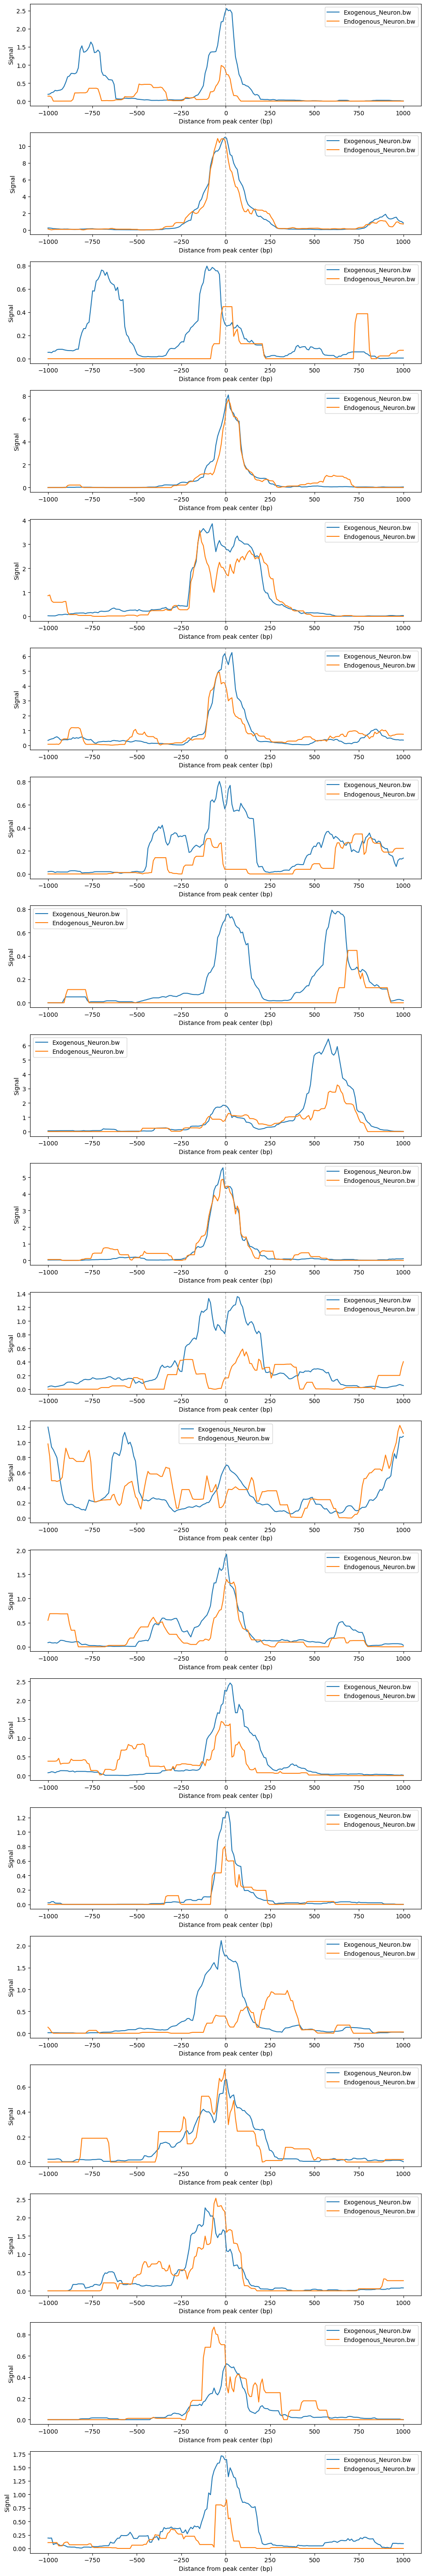

In [238]:
# Plot the signals
plot_peak_signals(filtered_peaks, bigwig_files, window_size=2000, num_peaks=20)